# Power Spectrum

imports

In [140]:
import os
import re
import gc
import sys
import glob
import yaml
import math
from scipy import stats
import numpy as np
import pandas as pd
from astropy.io import fits
import aicspylibczi as aplc
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib_scalebar.scalebar import ScaleBar


from turbustat.statistics import PowerSpectrum


In [99]:
%load_ext autoreload
%autoreload 2
functions_path = '/workdir/bmg224/manuscripts/mgefish/code/functions'

sys.path.append(cluster + functions_path)

import image_plots as ip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
def get_resolution(fn, dim='X'):
    czi = aplc.CziFile(fn)
    for n in czi.meta.iter():
        if 'Scaling' in n.tag:
            if dim in n.tag:
                resolution = float(n.text)
    return resolution

def _image_figure(dims, dpi=500):
    fig = plt.figure(figsize=(dims[0], dims[1]))
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    # ax.set_axis_off()
    fig.add_axes(ax)
    return(fig, ax)

def plot_image(
            im, im_inches=5, cmap='inferno', clims=('min','max'), zoom_coords=(), scalebar_resolution=0,
            axes_off=True, discrete=False, cbar_ori='horizontal', dpi=500,
            norm=None
        ):
    s = im.shape
    dims = (im_inches*s[1]/np.max(s), im_inches*s[0]/np.max(s))
    fig, ax = _image_figure(dims, dpi=dpi)
    im_ = im[~np.isnan(im)]
    llim = np.min(im_) if clims[0]=='min' else clims[0]
    ulim = np.max(im_) if clims[1]=='max' else clims[1]
    clims = (llim, ulim)
    if len(s) > 2:
        ax.imshow(im, interpolation="none")
    else:
        ax.imshow(im, cmap=cmap, clim=clims, interpolation="none", norm=norm)
    zc = zoom_coords if zoom_coords else (0,im.shape[0],0,im.shape[1])
    ax.set_ylim(zc[1],zc[0])
    ax.set_xlim(zc[2],zc[3])
    if axes_off:
        ax.set_axis_off()
    if scalebar_resolution:
        scalebar = ScaleBar(
                scalebar_resolution, 'um', frameon = False,
                color = 'white', box_color = 'white'
            )
        plt.gca().add_artist(scalebar)
    cbar = []
    fig2 = []
    if len(s) == 2:
        if cbar_ori == 'horizontal':
            fig2 = plt.figure(figsize=(dims[0], dims[0]/10))
        elif cbar_ori == 'vertical':
            fig2 = plt.figure(figsize=(dims[1]/10, dims[1]))
        if discrete:
            vals = np.sort(np.unique(im))
            vals = vals[~np.isnan(vals)]
            vals = vals[(vals>=clims[0]) & (vals<=clims[1])]
            cbar = get_discrete_colorbar(vals, cmap)
        else:
            image=plt.imshow(im, cmap=cmap, clim=clims, norm=norm)
            plt.gca().set_visible(False)
            cbar = plt.colorbar(image,orientation=cbar_ori)
    return(fig, ax, [fig2, cbar])


Get workdir

In [5]:
cluster = ""
workdir = "/workdir/bmg224/harvard_dental/manuscript/code"
os.chdir(cluster + workdir)


In [91]:
os.getcwd()

'/local/workdir/bmg224/harvard_dental/manuscript/code'

Get czi filenames

In [8]:
input_table_fn = "input_table_all.csv"
input_table = pd.read_csv(input_table_fn)
filenames = input_table["filenames"]

In [12]:
dict_date_sn_fns = defaultdict(lambda: defaultdict(list))
for fn in filenames:
    bn = os.path.split(fn)[1]
    date, bn = re.split("(?<=^\d{4}_\d{2}_\d{2})_", bn)
    sn, ext = re.split("(?<=fov_\d{2})", bn)
    dict_date_sn_fns[date][sn].append(fn)
dict_date_sn_fns

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_544464/2722532407.py:4: SyntaxWarning: invalid escape sequence '\d'
  date, bn = re.split("(?<=^\d{4}_\d{2}_\d{2})_", bn)
/tmp/ipykernel_544464/2722532407.py:5: SyntaxWarning: invalid escape sequence '\d'
  sn, ext = re.split("(?<=fov_\d{2})", bn)


defaultdict(<function __main__.<lambda>()>,
            {'2022_12_16': defaultdict(list,
                         {'harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01': ['../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01tile_las_488.czi',
                           '../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01tile_las_514.czi',
                           '../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01tile_las_561.czi'],
                          'harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02': ['../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02tile_las_488.czi',
                           '../../imaging/2022_12_16_harvardwelch/data/2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fo

Get processed filename formats

In [13]:
out_dir = "../outputs/segmentation_2024_03_07/{date}/{date}_{sn}"
out_fmt_classif = out_dir + "/classif"
centroid_sciname_fmt = out_fmt_classif + "/{date}_{sn}_centroid_sciname.csv"

Get color dict

In [14]:
sciname_list = [
    "Corynebacterium",
    "Actinomyces",
    "Rothia",
    "Capnocytophaga",
    "Prevotella",
    "Porphyromonas",
    "Streptococcus",
    "Gemella",
    "Veillonella",
    "Selenomonas",
    "Lautropia",
    "Neisseriaceae",
    "Pasteurellaceae",
    "Campylobacter",
    "Fusobacterium",
    "Leptotrichia",
    "Treponema",
    "TM7",
]
colors = plt.get_cmap("tab20").colors
# colors = [c + (1,) for c in colors]
dict_sciname_color = dict(zip(sciname_list, colors))
dict_sciname_color["Neisseria"] = dict_sciname_color["Neisseriaceae"]
dict_sciname_color["Saccharibacteria"] = dict_sciname_color["TM7"]
dict_sciname_color["TM"] = dict_sciname_color["TM7"]

## Test image

In [15]:
date = "2023_02_08"
sn = "hsdm_group_1_sample_12_fov_01"

centroid_sciname_fn = centroid_sciname_fmt.format(date=date, sn=sn)
centroid_sciname = pd.read_csv(centroid_sciname_fn)
coords = np.array([eval(c) for c in centroid_sciname["coord"].values])
scinames = centroid_sciname["sciname"].values
scn_unq = np.unique(scinames)


### Veillonella

Plot spot distribution

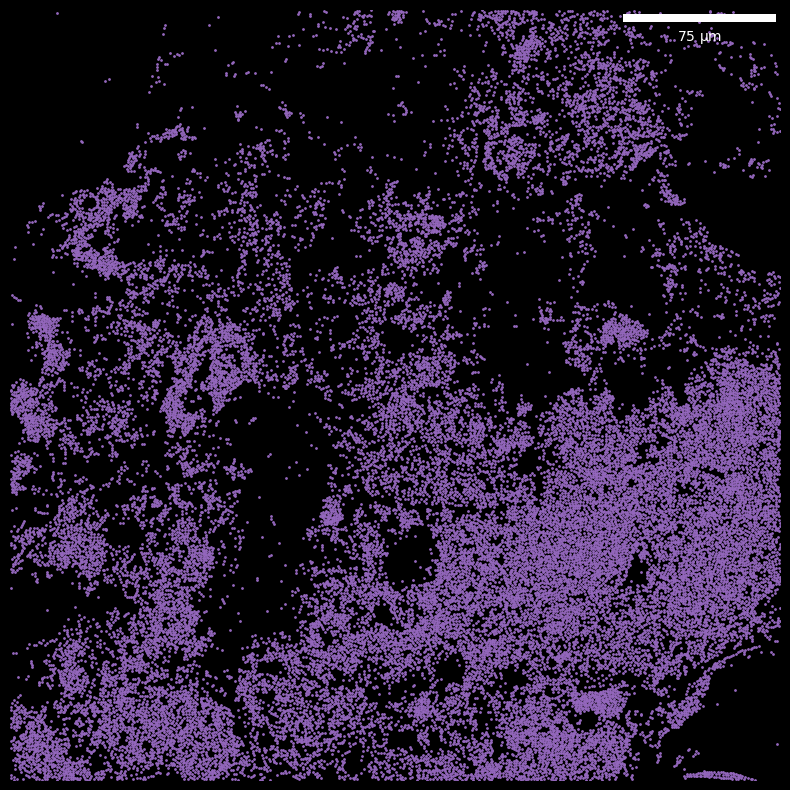

In [159]:
scn = 'Veillonella'

col = dict_sciname_color[scn]
spot_size = 1

res_umpix = get_resolution(dict_date_sn_fns[date][sn][0]) * 10**6

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

coords_scn = coords[scinames == scn]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(coords_scn[:,1], coords_scn[:,0], s=spot_size, color=col)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.patch.set_color('k')
fig.patch.set_facecolor('k')
ax.invert_yaxis()
ax.set_aspect('equal')

plt.axis('off')
scalebar = ScaleBar(res_umpix, 'um', frameon = False, color = 'white', box_color = 'white')
plt.gca().add_artist(scalebar)

spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/power_spectrum'
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_scatter.pdf'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)


Get density plot

In [160]:
radius_um = 10
step_um = 5

step = step_um / res_umpix
radius = radius_um / res_umpix
xs = np.arange(xlim[0],xlim[1], step)
ys = np.arange(ylim[0],ylim[1], step)

density_arr = np.zeros((len(rs), len(cs)))
for j, x in enumerate(xs): 
    eboolx = (
        (x > (xlim[0] + radius)) 
        * (x < (xlim[1] - radius))
    )
    if eboolx:
        for i, y in enumerate(ys):
            ebooly = (
                (y > (ylim[0] + radius)) 
                * (y < (ylim[1] - radius))
            )
            if ebooly:
                bools = (
                    (coords_scn[:,1] > (x - radius))
                    * (coords_scn[:,1] < (x + radius))
                    * (coords_scn[:,0] > (y - radius))
                    * (coords_scn[:,0] < (y + radius))
                )
                density_arr[i,j] = sum(bools) / (radius_um**2)


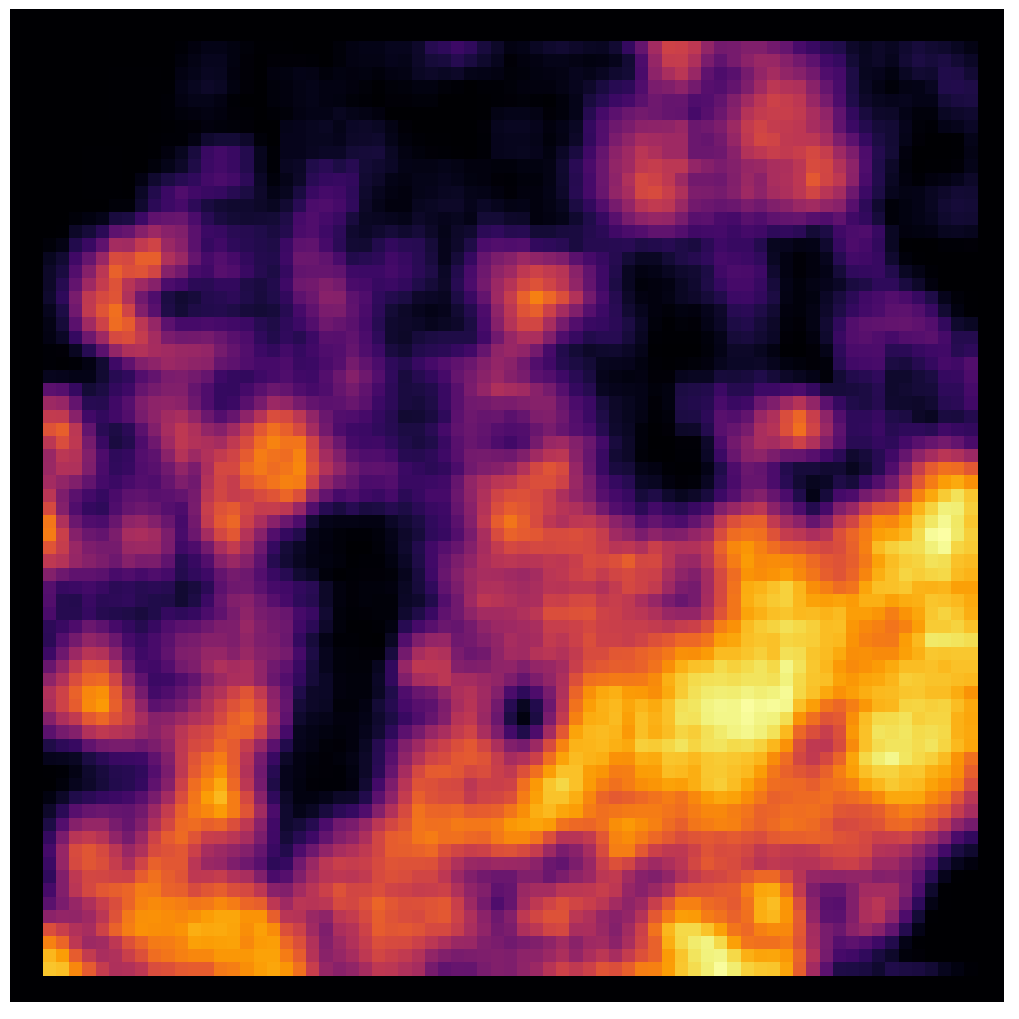

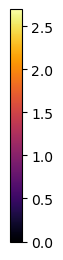

In [163]:
fig, ax, cbar = plot_image(
    density_arr, cmap='inferno', im_inches=10, cbar_ori='vertical'
)
plt.figure(fig)
spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/power_spectrum'
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_density.png'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)

plt.figure(cbar[0])
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_density_cbar.pdf'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)

Get power spectrum

In [75]:
hdr = fits.PrimaryHDU().header
hdr['CDELT1'] = step_um
hdr['CDELT2'] = step_um


/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     547.7
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.83e-29
Time:                        00:34:24   Log-Likelihood:                -17.974
No. Observations:                  54   AIC:                             39.95
Df Residuals:                      52   BIC:                             43.93
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5282      0.120      4.400      0.0

/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


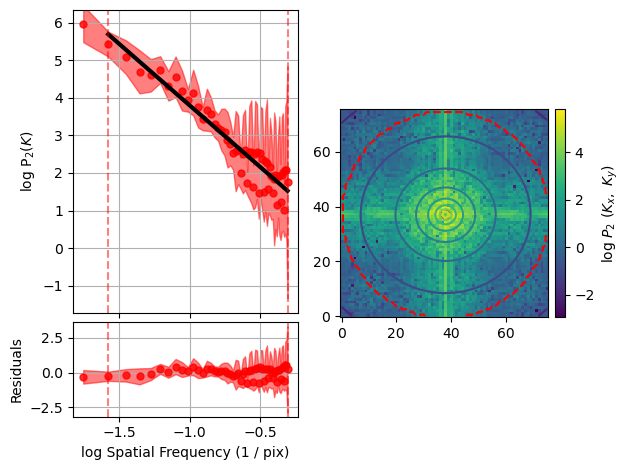

In [76]:
pspec = PowerSpectrum(density_arr, header=hdr)
pspec.run(verbose=True)

In [93]:
pspec.ps1D

array([4.87014076e+04, 1.34181607e+04, 1.90209494e+04, 1.09275478e+04,
       8.46782762e+03, 5.84446795e+03, 5.17720963e+03, 3.21017466e+03,
       2.16519291e+03, 1.46402116e+03, 1.23669354e+03, 9.17466748e+02,
       4.75425632e+02, 2.62893611e+02, 2.74070082e+02, 1.74340393e+02,
       1.54058397e+02, 1.19451177e+02, 1.10593271e+02, 9.72803608e+01,
       8.62850149e+01, 5.55835181e+01, 5.01365038e+01, 3.99766946e+01,
       2.01862924e+01, 2.35544173e+01, 1.89436141e+01, 7.81346833e+00,
       1.41892933e+01, 1.19995955e+01, 4.96958845e+00, 1.54208176e+01,
       1.19808654e+01, 5.25419763e+00, 1.55533132e+01, 1.48339101e+01,
       4.83505394e+00, 1.34957013e+01, 1.48587280e+01, 8.08685394e+00,
       1.26036090e+01, 6.16434828e+00, 7.09128292e+00, 8.21057788e+00,
       1.04949921e+01, 4.59192976e+00, 7.72650827e+00, 6.32744393e+00,
       1.54274121e+00, 4.48589603e+00, 5.28309494e+00, 1.01679800e+00,
       4.55092840e+00, 3.42834613e+00, 1.42979614e+00])

### Selenomonas

Plot spot distribution

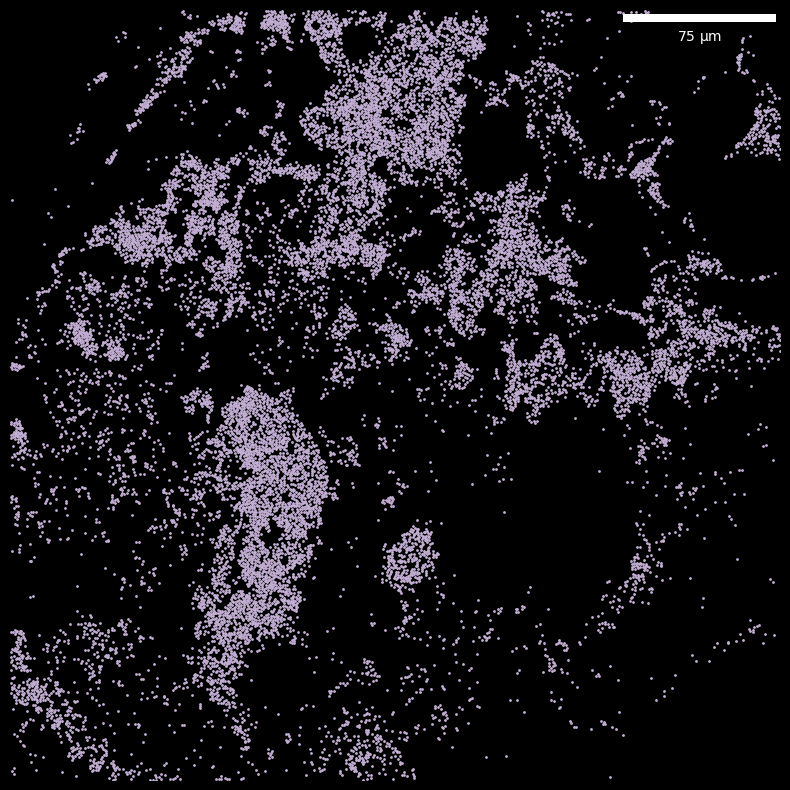

In [164]:
scn = 'Selenomonas'

col = dict_sciname_color[scn]
spot_size = 1

res_umpix = get_resolution(dict_date_sn_fns[date][sn][0]) * 10**6

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

coords_scn = coords[scinames == scn]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(coords_scn[:,1], coords_scn[:,0], s=spot_size, color=col)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.patch.set_color('k')
fig.patch.set_facecolor('k')
ax.invert_yaxis()
ax.set_aspect('equal')

plt.axis('off')
scalebar = ScaleBar(res_umpix, 'um', frameon = False, color = 'white', box_color = 'white')
plt.gca().add_artist(scalebar)


spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/power_spectrum'
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_scatter.pdf'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)



Get density plot

In [165]:
radius_um = 10
step_um = 5

step = step_um / res_umpix
radius = radius_um / res_umpix
xs = np.arange(xlim[0],xlim[1], step)
ys = np.arange(ylim[0],ylim[1], step)

density_arr = np.zeros((len(rs), len(cs)))
for j, x in enumerate(xs): 
    eboolx = (
        (x > (xlim[0] + radius)) 
        * (x < (xlim[1] - radius))
    )
    if eboolx:
        for i, y in enumerate(ys):
            ebooly = (
                (y > (ylim[0] + radius)) 
                * (y < (ylim[1] - radius))
            )
            if ebooly:
                bools = (
                    (coords_scn[:,1] > (x - radius))
                    * (coords_scn[:,1] < (x + radius))
                    * (coords_scn[:,0] > (y - radius))
                    * (coords_scn[:,0] < (y + radius))
                )
                density_arr[i,j] = sum(bools) / (radius_um**2)


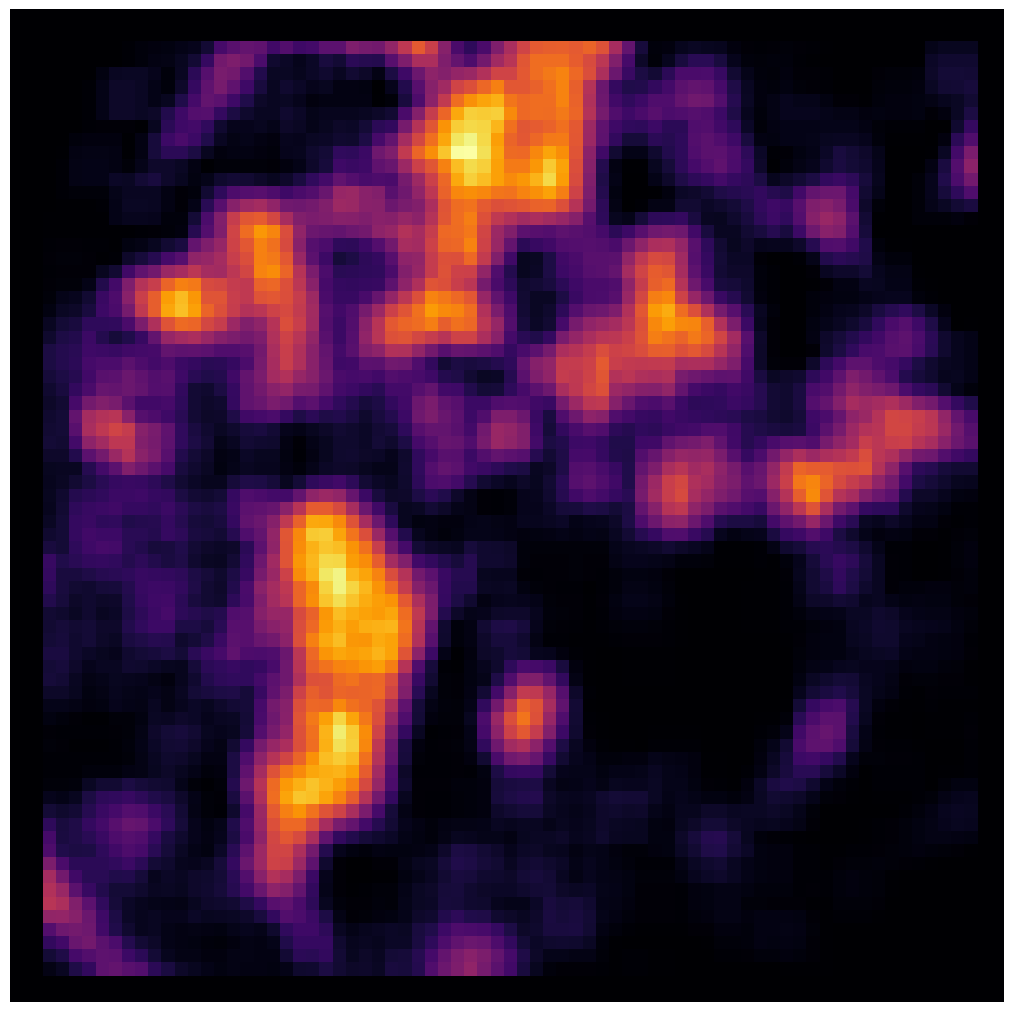

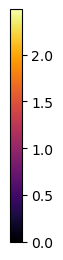

In [166]:
fig, ax, cbar = plot_image(
    density_arr, cmap='inferno', im_inches=10, cbar_ori='vertical'
)
plt.figure(fig)
spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/power_spectrum'
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_density.png'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)

plt.figure(cbar[0])
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn}_density_cbar.pdf'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn=scn)
ip.check_dir(out_fn)
ip.save_fig(out_fn, transp=False)

Get power spectrum

In [70]:
hdr = fits.PrimaryHDU().header
hdr['CDELT1'] = step_um
hdr['CDELT2'] = step_um


/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     460.9
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.65e-27
Time:                        00:32:30   Log-Likelihood:                -7.2399
No. Observations:                  54   AIC:                             18.48
Df Residuals:                      52   BIC:                             22.46
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1708      0.112     -1.519      0.1

/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


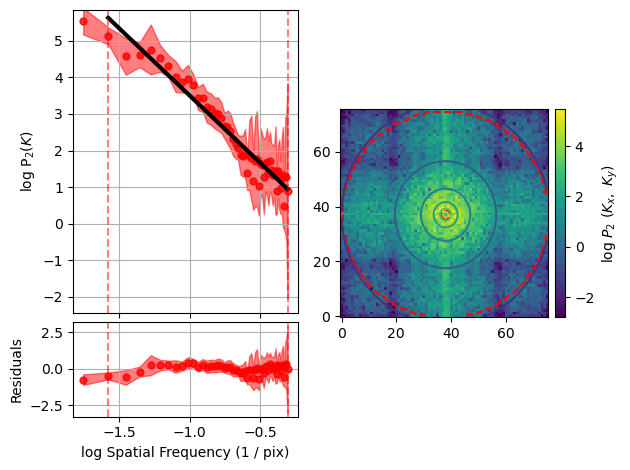

In [71]:
pspec = PowerSpectrum(density_arr, header=hdr)
pspec.run(verbose=True)

Gemella

Plot spot distribution

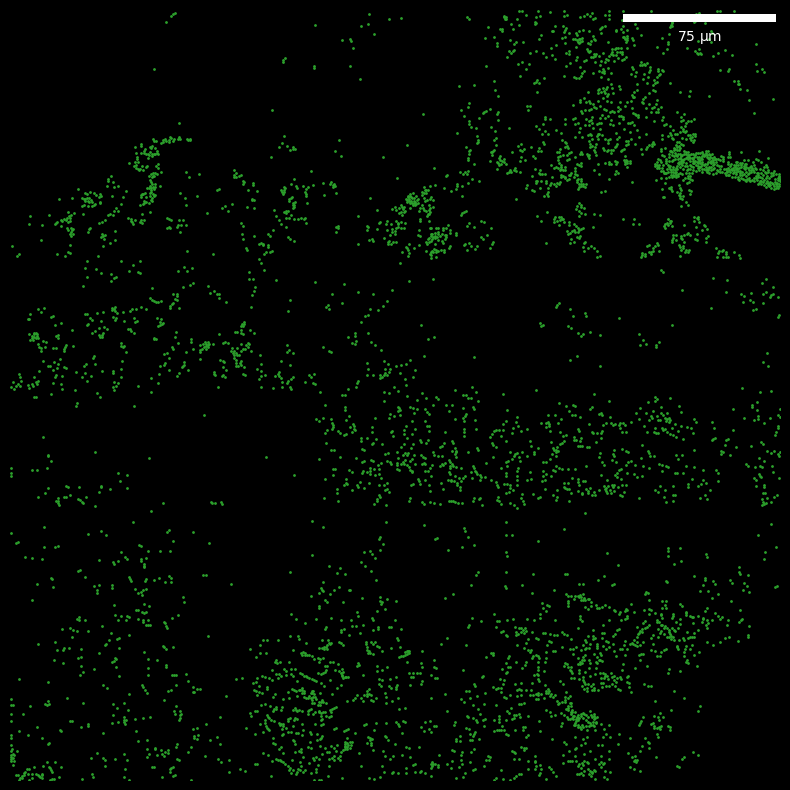

In [78]:
scn = 'Prevotella'

col = dict_sciname_color[scn]
spot_size = 1

res_umpix = get_resolution(dict_date_sn_fns[date][sn][0]) * 10**6

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

coords_scn = coords[scinames == scn]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(coords_scn[:,1], coords_scn[:,0], s=spot_size, color=col)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.patch.set_color('k')
fig.patch.set_facecolor('k')
ax.invert_yaxis()
ax.set_aspect('equal')

plt.axis('off')
scalebar = ScaleBar(res_umpix, 'um', frameon = False, color = 'white', box_color = 'white')
plt.gca().add_artist(scalebar)



Get density plot

In [79]:
radius_um = 10
step_um = 5

step = step_um / res_umpix
radius = radius_um / res_umpix
xs = np.arange(xlim[0],xlim[1], step)
ys = np.arange(ylim[0],ylim[1], step)

density_arr = np.zeros((len(rs), len(cs)))
for j, x in enumerate(xs): 
    eboolx = (
        (x > (xlim[0] + radius)) 
        * (x < (xlim[1] - radius))
    )
    if eboolx:
        for i, y in enumerate(ys):
            ebooly = (
                (y > (ylim[0] + radius)) 
                * (y < (ylim[1] - radius))
            )
            if ebooly:
                bools = (
                    (coords_scn[:,1] > (x - radius))
                    * (coords_scn[:,1] < (x + radius))
                    * (coords_scn[:,0] > (y - radius))
                    * (coords_scn[:,0] < (y + radius))
                )
                density_arr[i,j] = sum(bools) / (radius_um**2)


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 [<Figure size 1000x100 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f5ddcb5e870>])

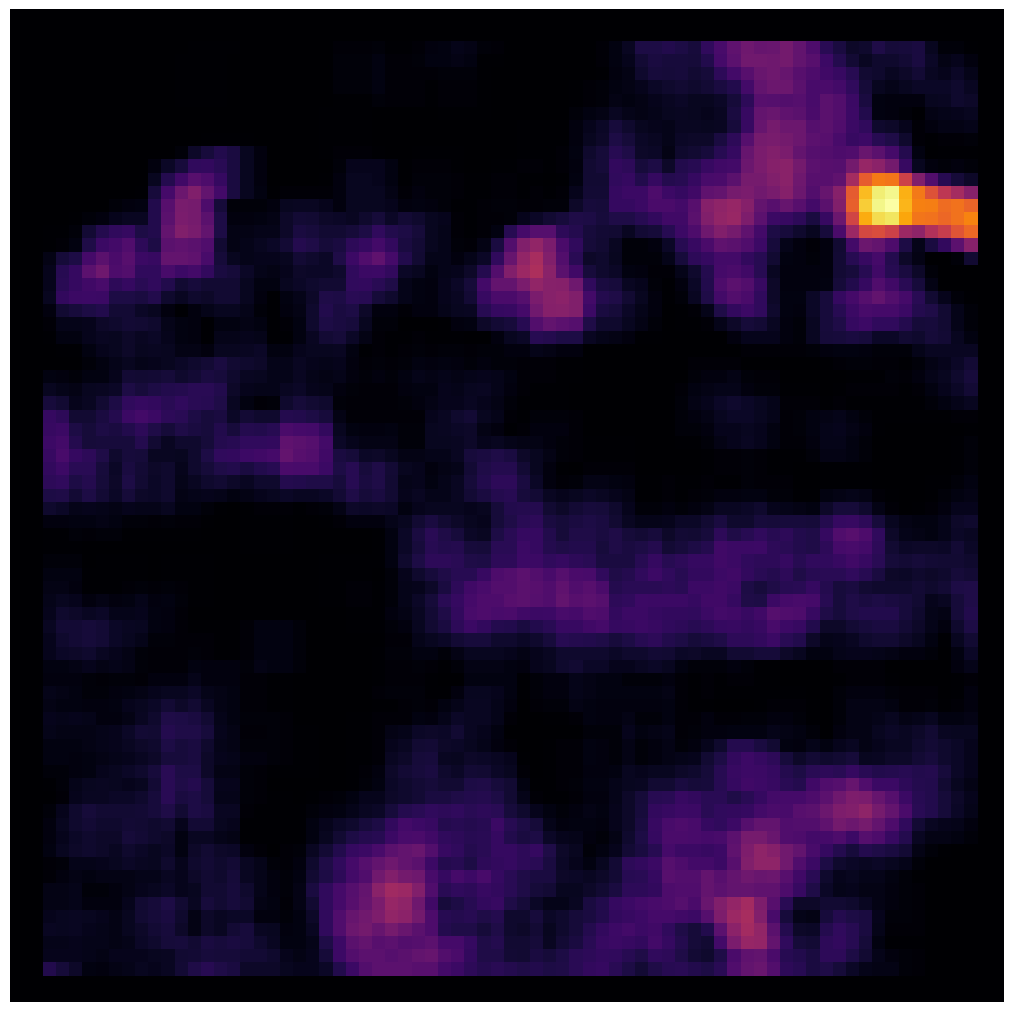

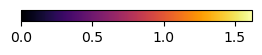

In [80]:
plot_image(density_arr, cmap='inferno', im_inches=10)

Get power spectrum

In [81]:
hdr = fits.PrimaryHDU().header
hdr['CDELT1'] = step_um
hdr['CDELT2'] = step_um


/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     507.9
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.69e-28
Time:                        00:36:21   Log-Likelihood:                -1.3377
No. Observations:                  54   AIC:                             6.675
Df Residuals:                      52   BIC:                             10.65
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6899      0.094     -7.318      0.0

/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


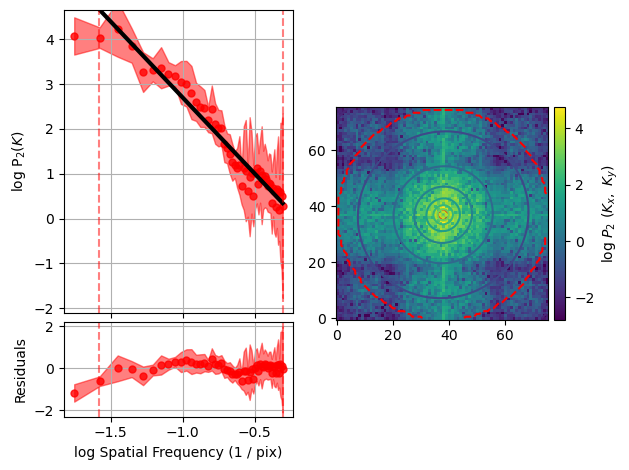

In [82]:
pspec = PowerSpectrum(density_arr, header=hdr)
pspec.run(verbose=True)

### Gemella

Plot spot distribution

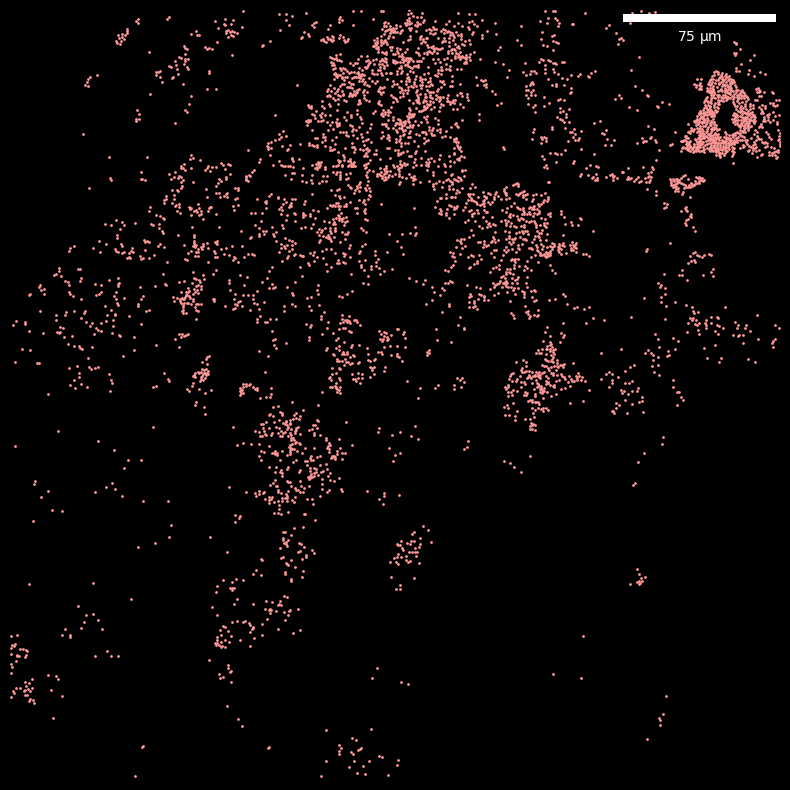

In [84]:
scn = 'Gemella'

col = dict_sciname_color[scn]
spot_size = 1

res_umpix = get_resolution(dict_date_sn_fns[date][sn][0]) * 10**6

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

coords_scn = coords[scinames == scn]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(coords_scn[:,1], coords_scn[:,0], s=spot_size, color=col)
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.patch.set_color('k')
fig.patch.set_facecolor('k')
ax.invert_yaxis()
ax.set_aspect('equal')

plt.axis('off')
scalebar = ScaleBar(res_umpix, 'um', frameon = False, color = 'white', box_color = 'white')
plt.gca().add_artist(scalebar)



Get density plot

In [85]:
radius_um = 10
step_um = 5

step = step_um / res_umpix
radius = radius_um / res_umpix
xs = np.arange(xlim[0],xlim[1], step)
ys = np.arange(ylim[0],ylim[1], step)

density_arr = np.zeros((len(rs), len(cs)))
for j, x in enumerate(xs): 
    eboolx = (
        (x > (xlim[0] + radius)) 
        * (x < (xlim[1] - radius))
    )
    if eboolx:
        for i, y in enumerate(ys):
            ebooly = (
                (y > (ylim[0] + radius)) 
                * (y < (ylim[1] - radius))
            )
            if ebooly:
                bools = (
                    (coords_scn[:,1] > (x - radius))
                    * (coords_scn[:,1] < (x + radius))
                    * (coords_scn[:,0] > (y - radius))
                    * (coords_scn[:,0] < (y + radius))
                )
                density_arr[i,j] = sum(bools) / (radius_um**2)


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 [<Figure size 1000x100 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f5ddcb5e9c0>])

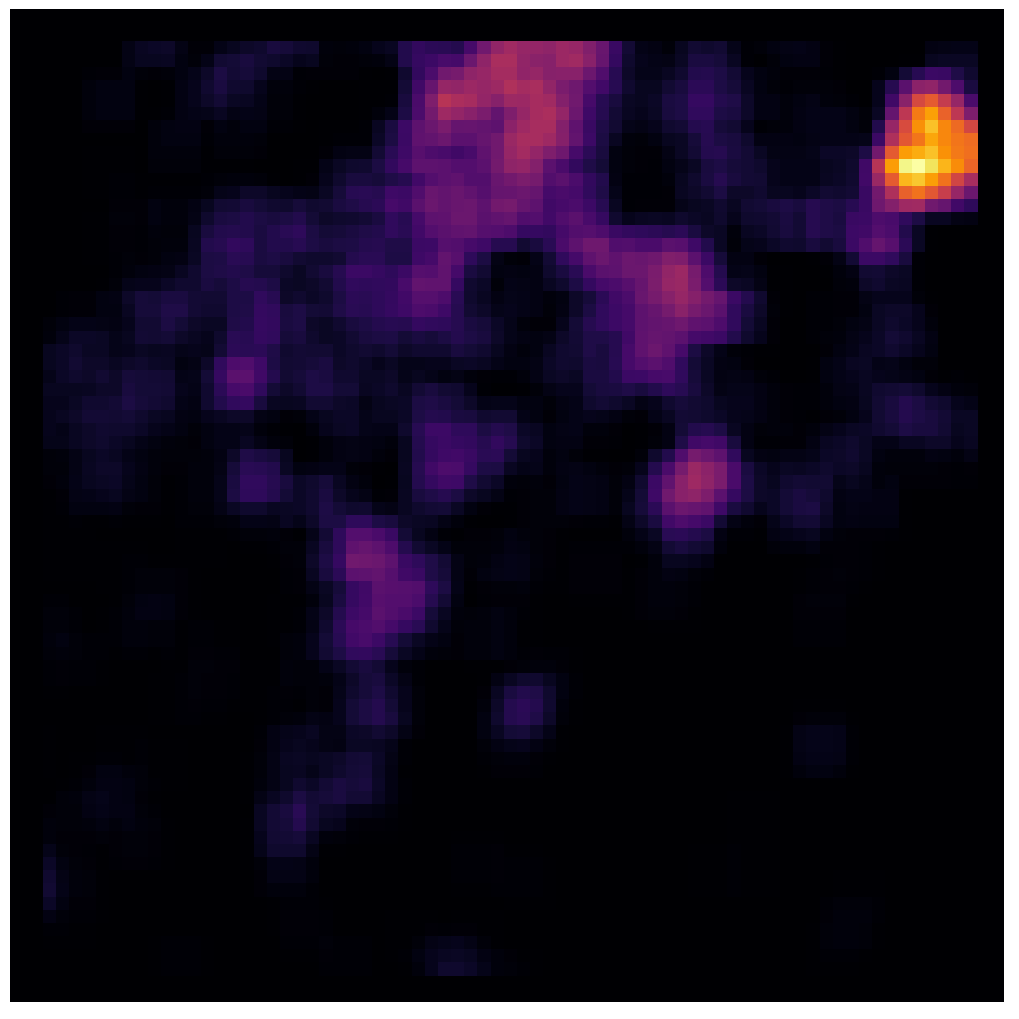

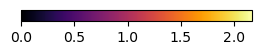

In [86]:
plot_image(density_arr, cmap='inferno', im_inches=10)

Get power spectrum

In [87]:
hdr = fits.PrimaryHDU().header
hdr['CDELT1'] = step_um
hdr['CDELT2'] = step_um


/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     377.6
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.68e-25
Time:                        00:43:42   Log-Likelihood:                -1.5310
No. Observations:                  54   AIC:                             7.062
Df Residuals:                      52   BIC:                             11.04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6755      0.116     -5.841      0.0

/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/elliptical_powerlaw.py:253: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


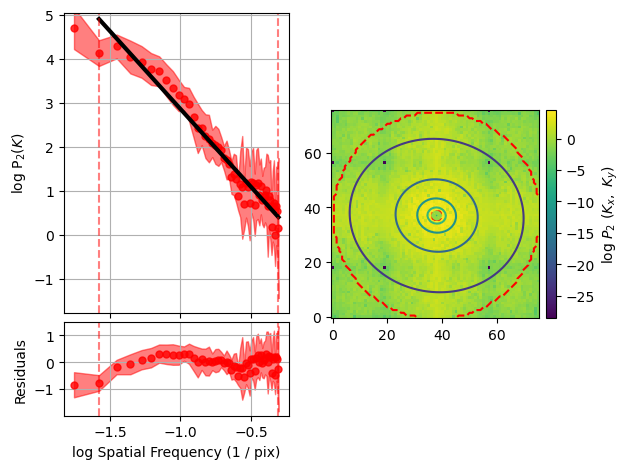

In [88]:
pspec = PowerSpectrum(density_arr, header=hdr)
pspec.run(verbose=True)

### Comopare curves

In [94]:
def get_density_arr(coords_scn, step, radius):
    xs = np.arange(xlim[0],xlim[1], step)
    ys = np.arange(ylim[0],ylim[1], step)

    density_arr = np.zeros((len(ys), len(xs)))
    for j, x in enumerate(xs): 
        eboolx = (
            (x > (xlim[0] + radius)) 
            * (x < (xlim[1] - radius))
        )
        if eboolx:
            for i, y in enumerate(ys):
                ebooly = (
                    (y > (ylim[0] + radius)) 
                    * (y < (ylim[1] - radius))
                )
                if ebooly:
                    bools = (
                        (coords_scn[:,1] > (x - radius))
                        * (coords_scn[:,1] < (x + radius))
                        * (coords_scn[:,0] > (y - radius))
                        * (coords_scn[:,0] < (y + radius))
                    )
                    density_arr[i,j] = sum(bools) / (radius_um**2)
    return density_arr

/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Slope: -3.4515500424592824 rsquared: 0.9035769287883001


/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/bmg224/miniconda3/envs/turbustat/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Slope: -4.000585921767897 rsquared: 0.9462184534718489


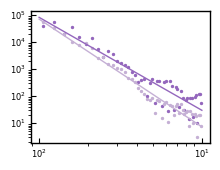

In [150]:
radius_um = 10
step_um = 5

res_umpix = get_resolution(dict_date_sn_fns[date][sn][0]) * 10**6
step = step_um / res_umpix
radius = radius_um / res_umpix

xlim = (0, np.max(coords[:, 1]))
ylim = (0, np.max(coords[:, 0]))

hdr = fits.PrimaryHDU().header
hdr['CDELT1'] = step_um
hdr['CDELT2'] = step_um

dims = (2,1.5)
ft=6
lw=1
s=2

fmin = 1e-2
fmax = 1e-1

fig, ax = ip.general_plot(dims=dims, ft=ft, lw=lw)
scns = ['Veillonella','Selenomonas']
for scn in scns:
    # Setup
    col = dict_sciname_color[scn]
    coords_scn = coords[scinames == scn]

    # Get density
    density_arr = get_density_arr(coords_scn, step, radius)
    pspec = PowerSpectrum(density_arr, header=hdr)
    _ = pspec.run()

    # Plot 
    freqs = pspec.freqs.value / step_um
    bool_l = freqs > fmin
    bool_u = freqs < fmax
    freqs_clip = freqs[bool_l * bool_u]
    ps1D_clip = pspec.ps1D[bool_l * bool_u]

    ax.scatter(freqs_clip, ps1D_clip, color=col, s=s)

    lnc = np.log(freqs_clip)
    lnp = np.log(ps1D_clip)
    slope, intercept, r_value, p_value, std_err = stats.linregress(lnc, lnp)

    # intercept, slope = pspec.fit.params
    x = np.array([fmin, fmax])
    # x = np.array([pspec.low_cut.value, pspec.high_cut.value])
    y = math.exp(intercept) * x**slope
    ax.plot(x,y, color=col, lw=lw)
    print('Slope:',slope, "rsquared:", pspec.fit.rsquared)    

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks([1e-2, 1e-1], labels=[r"$10^{2}$", r"$10^{1}$"])

spatial_dir = out_dir + '/spatial_statistics'
cl_size_dir = spatial_dir + '/power_spectrum'
cluster_slope_fmt = cl_size_dir + '/plots/{date}_{sn}_scinames_{scn0}_{scn1}_power_spectrum.pdf'
out_fn = cluster_slope_fmt.format(date=date, sn=sn, scn0=scns[0], scn1=scns[1])
ip.check_dir(out_fn)
ip.save_fig(out_fn)

In [ ]:
intercept


: 

In [128]:
pspec.low_cut.value

0.02631578947368421

In [100]:
dir(pspec)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ang_size',
 '_angular_equiv',
 '_azim_constraint_flag',
 '_bootstrap_flag',
 '_brk',
 '_brk_err',
 '_data',
 '_ellip2D',
 '_ellip2D_err',
 '_fitter',
 '_freqs',
 '_has_spectral',
 '_header',
 '_physical_equiv',
 '_physical_size',
 '_ps1D',
 '_ps1D_stddev',
 '_ps2D',
 '_slope',
 '_slope2D',
 '_slope2D_err',
 '_slope_err',
 '_spatial_freq_unit_conversion',
 '_spatial_unit_conversion',
 '_spectral_equiv',
 '_spectral_freq_unit_conversion',
 '_spectral_size',
 '_theta2D',
 '_theta2D_err',
 '_to_angular',
 '_to_physical',
 '_to_pixel',
 '_to_pixel_area',
 '_to_pixel_freq',
 '_to_spectral',
 '_wcs',
 'apodizi

In [111]:
pspec.fit.rsquared

0.9526325877655389

In [110]:
dir(pspec.fit)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_interface__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__ceil__',
 '__class__',
 '__class_getitem__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getformat__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof_